In [1]:
# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
from numpy import log,dot,exp,shape
import cv2
import matplotlib.pyplot as plt
import timeit
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int64)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [2]:
#train dataset is loading
X_train, Y_train = read_hoda_dataset(dataset_path='./DigitDB/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)

#test dataset is loading
X_test, Y_test = read_hoda_dataset(dataset_path='./DigitDB/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

#remaining dataset is loading
X_remaining, Y_remaining = read_hoda_dataset('./DigitDB/RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=False,
                                             reshape=True)

print("Dataset is loaded.")

Dataset is loaded.


In [5]:
%%capture

#start time of the algorithm
start = timeit.default_timer()

import scipy.optimize as opt

# training data
Xtrain = X_train
Ytrain = Y_train

# test data
Xtest = X_test
Ytest = Y_test

# remaining data
Xremain = X_remaining
Yremain = Y_remaining


# Adds a column to the left side of the feature matrix (the intercept)
Xtrain = np.hstack((np.ones((len(Ytrain), 1)), Xtrain))
Xtest = np.hstack((np.ones((len(Ytest), 1)), Xtest)) 
Xremain = np.hstack((np.ones((len(Yremain), 1)), Xremain))

# the sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

# the LogLoss function (cost function) with Regularization
def LogLoss(W, X, Y, alpha):
    p_y = sigmoid(np.dot(X, W)) # y = np.dot(X, W)
    
    #calclulating the Log Loss
    lg = (np.sum((np.multiply(Y, np.log(p_y))) + (np.multiply(1-Y, np.log(1-p_y)))))/(-len(Y))
    
    # applying Regularization using norm2
    W_norm2 = np.linalg.norm(W[1:], ord=None, axis=None, keepdims=False) # (W_transpose).W
    
    return lg + W_norm2*alpha/(2*(len(Y)))
    
    # applying Regularization using norm1
    #W_norm1 = np.linalg.norm(W[1:], ord = 1, axis=None, keepdims=False)
    #return lg + W_norm1*alpha/(2*(len(Y)))
    

    
# the Gradient descent function   
def grad(W, X, Y, alpha):  # with Regularization
    m = len(Y)
    temp = sigmoid(np.dot(X, W)) - Y
    temp = (np.dot(temp.T, X).T / m)
    return temp 


number_of_classes = 10 
n = len(Xtrain[0])

# W : contains the coefficients (one row for each number)
W = np.zeros((number_of_classes, n))


# regularization parameter 
alpha = 0.1

#calculating the coefficient matrix
#max iterations = 20
for i in range(number_of_classes):
    W[i] = opt.fmin_cg(f = LogLoss, x0 = W[i],  fprime = grad, args = (Xtrain, (Ytrain == i).flatten(), alpha), maxiter = 20)
    
stop = timeit.default_timer()

In [6]:
# which class(0-9) is most probable for each data point?
train_predict = np.argmax(np.dot(Xtrain, W.T), axis = 1)
#printing the accuracy
print("train accuracy : ", np.mean(train_predict == Ytrain.flatten()) * 100)

test_predict = np.argmax(np.dot(Xtest, W.T), axis = 1)
print("test accuracy : ",np.mean(test_predict == Ytest.flatten()) * 100)

remain_predict = np.argmax(np.dot(Xremain, W.T), axis = 1)
print("remaining accuracy : ",np.mean(remain_predict == Yremain.flatten()) * 100)

train accuracy :  95.875
test accuracy :  91.485
remaining accuracy :  92.80601288475305


The predicted number is:  0


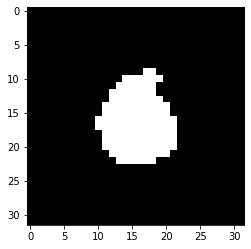

In [7]:
#testing samples
print("The predicted number is: ", test_predict[50])
plt.imshow(X_test[50].reshape([32, 32]), cmap='gray')

The predicted number is:  1


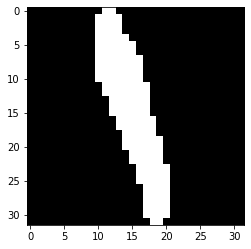

In [8]:
print("The predicted number is: ", test_predict[2000])
plt.imshow(X_test[2000].reshape([32, 32]), cmap='gray')

The predicted number is:  4


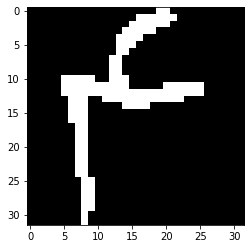

In [9]:
print("The predicted number is: ", test_predict[9000])
plt.imshow(X_test[9000].reshape([32, 32]), cmap='gray')

The predicted number is:  9


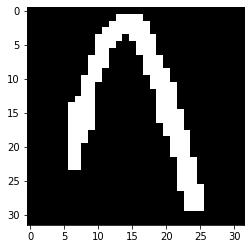

In [10]:
#wrongly predicted
print("The predicted number is: ", test_predict[16000])
plt.imshow(X_test[16000].reshape([32, 32]), cmap='gray')

AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2000
         1.0       0.91      0.97      0.94      2000
         2.0       0.83      0.83      0.83      2000
         3.0       0.88      0.85      0.86      2000
         4.0       0.89      0.86      0.87      2000
         5.0       0.95      0.97      0.96      2000
         6.0       0.92      0.87      0.89      2000
         7.0       0.97      0.95      0.96      2000
         8.0       0.97      0.94      0.95      2000
         9.0       0.88      0.93      0.90      2000

    accuracy                           0.91     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.91      0.91     20000



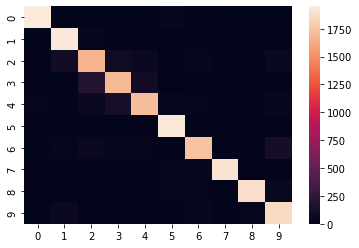

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_m = confusion_matrix(Ytest, test_predict)
import seaborn as sns
#printing precision, recall and f-1 score
print(sns.heatmap(confusion_m, annot = False))
#printing the heatmap
print(classification_report(Ytest, test_predict))

In [12]:
%%capture
#using built-in python function for logistic regression
start1 = timeit.default_timer()
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, Y_train)

stop1 = timeit.default_timer()

AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2000
         1.0       0.93      0.97      0.95      2000
         2.0       0.84      0.87      0.86      2000
         3.0       0.89      0.86      0.88      2000
         4.0       0.87      0.88      0.88      2000
         5.0       0.96      0.95      0.96      2000
         6.0       0.91      0.90      0.90      2000
         7.0       0.98      0.96      0.97      2000
         8.0       0.97      0.94      0.95      2000
         9.0       0.92      0.92      0.92      2000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



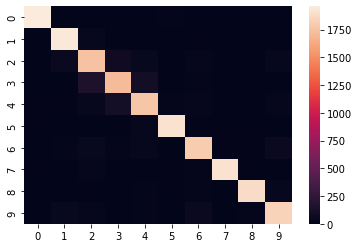

In [13]:
#printing precision, recall, f1-score and the heatmap for comparison
confusion_m2 = confusion_matrix(Y_test, logistic_reg.predict(X_test))
print(sns.heatmap(confusion_m2, annot = False))
print(classification_report(Y_test, logistic_reg.predict(X_test)))

In [14]:
print("Our logistic regression running time: ", stop - start) 
print("Built-in logistic regression running time: ", stop1 - start1) 

Our logistic regression running time:  66.39345349999999
Built-in logistic regression running time:  29.761046599999986
